In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

from astropy.io import fits

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [5]:
import pysiaf
siaf_nrc = pysiaf.Siaf('NIRCam')
siaf_nrc.generate_toc()

In [6]:
apname='NRCB5_SUB400P'
fov_pix = 401
oversample = 4

In [7]:
nrc = pynrc.NIRCam(filter='F410M', apname=apname, fov_pix=fov_pix, oversample=oversample, 
                   include_si_wfe=True)

In [8]:
psf0 = nrc.gen_psf()

In [63]:
from copy import deepcopy
kwargs = deepcopy(nrc.psf_info)
kwargs['pupil'] = nrc.pupil
kwargs.pop('save', None)
kwargs.pop('force', None)
kwargs.pop('include_si_wfe', None)
kwargs.pop('offset_r', None)
kwargs.pop('offset_theta', None)

0

In [64]:
kwargs

{'fov_pix': 401,
 'oversample': 4,
 'tel_pupil': None,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0),
 'jitter': 'gaussian',
 'jitter_sigma': 0.007,
 'pupil': 'CLEAR'}

In [10]:
cf_resid = nrc_utils.field_coeff(nrc.filter, nrc.psf_coeff, module=nrc.module, **kwargs)

In [11]:
ap = nrc.siaf_ap
v2, v3 = ap.convert(200, 200, 'sci', 'tel')  # arcsec

sep_arr = np.array([0,2,4,6])
v2_asec = np.ones(sep_arr.shape) + v2
v3_asec = np.array([v3+sep for sep in sep_arr])

In [12]:
%time cf_new_all = nrc.psf_coeff + nrc_utils.field_model(v2_asec/60, v3_asec/60, cf_resid)

CPU times: user 4.56 s, sys: 876 ms, total: 5.44 s
Wall time: 1.71 s


In [13]:
psf_all = []
for cf_new in cf_new_all:
    psf = nrc_utils.gen_image_coeff(nrc.filter, pupil=nrc.pupil, mask=nrc.mask, module=nrc.module, 
                                    coeff=cf_new, fov_pix=fov_pix, oversample=oversample)
    psf_all.append(psf)

~7th mag primary, with a K=[7,8,9] mag secondary at [2”, 4”, and 6”]

A5 primary, with an A5, G0 and K5 companion

F212N and F405N

F210M / F410M

F200W / F444W

In [35]:
bp_k = nrc_utils.bp_2mass('k')

sp_A5 = pynrc.stellar_spectrum('A5V', 7, 'vegamag', bp_k)
sp_G0 = pynrc.stellar_spectrum('A5V', 8, 'vegamag', bp_k)
sp_K5 = pynrc.stellar_spectrum('A5V', 9, 'vegamag', bp_k)

In [36]:
from pynrc.nrc_utils import gen_image_coeff

In [37]:
psf0 = gen_image_coeff(nrc.filter, pupil=nrc.pupil, mask=nrc.mask, module=nrc.module, sp_norm=sp_A5,
                       coeff=cf_new_all[0], fov_pix=fov_pix, oversample=oversample)

In [40]:
psfs_A5 = []
for cf_new in cf_new_all:
    psf = gen_image_coeff(nrc.filter, pupil=nrc.pupil, mask=nrc.mask, module=nrc.module, sp_norm=sp_A5, 
                          coeff=cf_new, fov_pix=fov_pix, oversample=oversample)
    psfs_A5.append(psf)

In [41]:
psfs_G0 = []
for cf_new in cf_new_all:
    psf = gen_image_coeff(nrc.filter, pupil=nrc.pupil, mask=nrc.mask, module=nrc.module, sp_norm=sp_G0, 
                          coeff=cf_new, fov_pix=fov_pix, oversample=oversample)
    psfs_G0.append(psf)

In [42]:
psfs_K5 = []
for cf_new in cf_new_all:
    psf = gen_image_coeff(nrc.filter, pupil=nrc.pupil, mask=nrc.mask, module=nrc.module, sp_norm=sp_K5, 
                          coeff=cf_new, fov_pix=fov_pix, oversample=oversample)
    psfs_K5.append(psf)

2.5118864315095726 -8.465169372848909e-17 5.290730858030568e-18


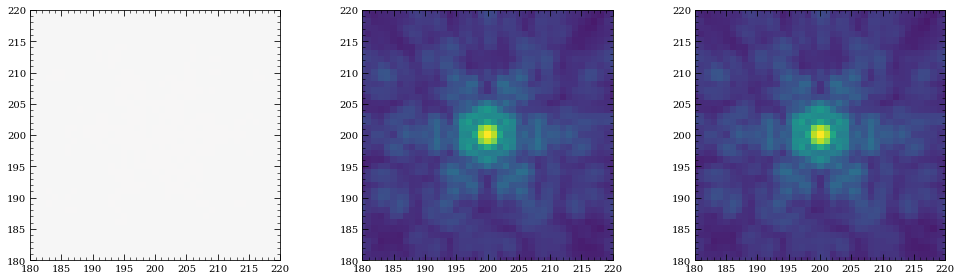

In [62]:
im1 = psf0
im2 = psfs_G0[0]
ratio = im1.sum() / im2.sum()
diff = (im1 - im2*ratio) / im2.sum()

import matplotlib.cm as cm
minmax = 5e-4

fig, axes = plt.subplots(1,3, figsize=(14,4))
axes[0].imshow(diff, vmin=-minmax, vmax=minmax, cmap=cm.RdBu)
axes[1].imshow(im1**0.2)
axes[2].imshow(im2**0.2)

print(ratio, np.min(diff), np.max(diff))

for ax in axes:
    ax.set_xlim([180,220])
    ax.set_ylim([180,220])
    
fig.tight_layout()

In [27]:
print(obs0.countrate()/obs0_norm.countrate(), obs0_norm.effstim('vegamag')-obs0.effstim('vegamag'))

8.628221214280928e+18 47.339803178034416


In [14]:
kwargs

{'fov_pix': 401,
 'oversample': 4,
 'tel_pupil': None,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0),
 'jitter': 'gaussian',
 'jitter_sigma': 0.007,
 'pupil': 'CLEAR'}

In [15]:
wpsf_a = nrc_utils.gen_webbpsf_siwfe(nrc.filter, (v2_asec[0], v3_asec[0]), **kwargs)
wpsf_b = nrc_utils.gen_webbpsf_siwfe(nrc.filter, (v2_asec[-1], v3_asec[-1]), **kwargs)

NRCB5 (1831.987947898948, 1848.1500601299413)
NRCB5 (1832.3954940684293, 1944.0272786502796)


-0.0001448672452480041 0.000343602273351451


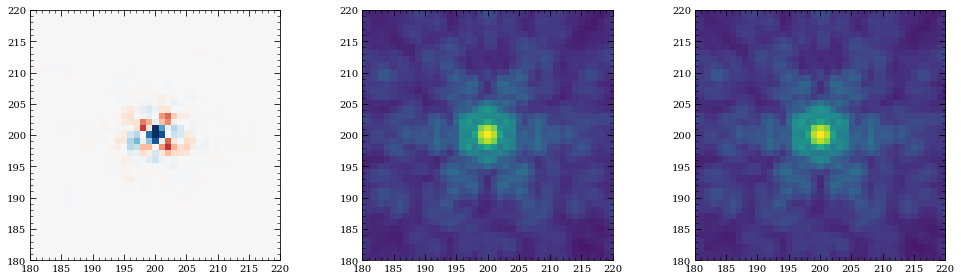

In [16]:
im1 = wpsf_a[1].data
im2 = wpsf_b[1].data
diff = im1 - im2

import matplotlib.cm as cm
minmax = 2e-4

fig, axes = plt.subplots(1,3, figsize=(14,4))
axes[0].imshow(diff, vmin=-minmax, vmax=minmax, cmap=cm.RdBu)
axes[1].imshow(im1**0.2)
axes[2].imshow(im2**0.2)

print(np.min(diff), np.max(diff))

for ax in axes:
    ax.set_xlim([180,220])
    ax.set_ylim([180,220])
    
fig.tight_layout()

-6.809543780388321e-05 9.50669141781546e-05


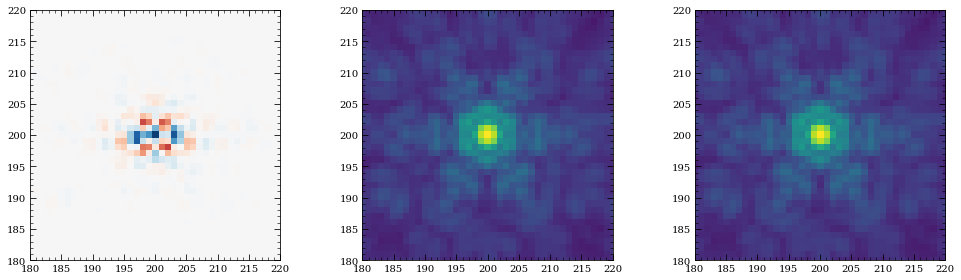

In [17]:
im1 = psf_all[0]
im2 = psf_all[-1]
diff = im1 - im2

import matplotlib.cm as cm
minmax = 1e-4

fig, axes = plt.subplots(1,3, figsize=(14,4))
axes[0].imshow(diff, vmin=-minmax, vmax=minmax, cmap=cm.RdBu)
axes[1].imshow(im1**0.2)
axes[2].imshow(im2**0.2)

print(np.min(diff), np.max(diff))

for ax in axes:
    ax.set_xlim([180,220])
    ax.set_ylim([180,220])
    
fig.tight_layout()

In [23]:
from pynrc import nrc_utils
from pynrc import NIRCam

In [ ]:
class nrc_field_wfe(NIRCam):
    """NIRCam class with field-dependent coefficient

    Subclass of the :mod:`~pynrc.NIRCam` instrument class with updates for PSF
    generation of WFE variations across the field.

    Parameters
    ----------
    wind_mode : str
        'FULL', 'STRIPE', or 'WINDOW'
    xpix : int
        Size of the detector readout along the x-axis. The detector is
        assumed to be in window mode  unless the user explicitly
        sets wind_mode='FULL'.
    ypix : int
        Size of the detector readout along the y-axis. The detector is
        assumed to be in window mode  unless the user explicitly
        sets wind_mode='FULL'.

    """

    def __init__(self, verbose=False, **kwargs):

        #super(NIRCam,self).__init__(**kwargs)
        NIRCam.__init__(self, **kwargs)

        # Background/off-axis PSF coeff updates
        # -------------------------------------
        # Background PSF should be same size as primary PSF
        # Used to generate position-dependent off-axis PSFs
        if self.mask is not None:
            if verbose: print("Generating background PSF coefficients...")
            log_prev = conf.logging_level
            self._fov_pix_bg = self.psf_info['fov_pix']
            setup_logging('WARN', verbose=False)
            self.update_psf_coeff()
            setup_logging(log_prev, verbose=False)

        # Cached PSFs
        # -----------
        # Generate cached PSFs for quick retrieval.
        # A PSF centered on the mask and one fully off-axis.
        if verbose: print("Generating oversampled PSFs...")
        self._gen_cached_psfs()

        # Set locations based on detector
        self._set_xypos()
        # Create mask throughput images seen by each detector
        self._gen_cmask()